## import & load

In [2]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [3]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

In [4]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')
    os.environ["GOOGLE_CLOUD_PROJECT"] = "trading-290017"
else:
    print('the credential.json file does not exist')

import importlib

In [5]:
import market_data.ingest.bq.cache
importlib.reload(market_data.ingest.bq.common)
importlib.reload(market_data.ingest.bq.cache)

<module 'market_data.ingest.bq.cache' from '/Users/junlim/projects/jitter_recovery/market_data/ingest/bq/cache.py'>

In [29]:
date_str_from='2024-04-01'
date_str_to='2024-04-14'
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE

In [995]:
df = market_data.ingest.bq.cache.fetch_and_cache(
    dataset_mode, 
    export_mode, 
    market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from=date_str_from, date_str_to=date_str_to).reset_index()
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])

In [996]:
all_symbols = df.symbol.unique()
all_symbols = [s for s in all_symbols if s]
len([s for s in all_symbols if 'USDT' in s])

185

## calculate/cache feature

In [7]:
import algo.feature.momentum.calculate
importlib.reload(algo.feature.momentum.calculate)
import algo.feature.momentum.research
importlib.reload(algo.feature.momentum.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/Users/junlim/projects/jitter_recovery/algo/cache.py'>

In [8]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(window=360, ema_window=60)

In [9]:
algo.feature.momentum.research.get_feature_label_for_caching(feature_param)

'feature/(momentum)_window(360)_ema_window(60)'

In [35]:
dfst_feature = algo.cache.read_df(
    label = algo.feature.momentum.research.get_feature_label_for_caching(feature_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.GEMINI,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-01', 
    date_str_to='2024-04-30')

In [36]:
algo.feature.momentum.research.get_feature_label_for_caching(feature_param)

'feature/(momentum)_window(180)_ema_window(30)'

In [1041]:
dfst_feature.columns

Index(['index', 'open', 'high', 'low', 'close', 'volume', 'value', 'ema', 'ch',
       'ch_ema', 'momentum', 'rank', 'rank_descending'],
      dtype='object')

## multiple symbols

In [10]:
import algo.alpha.momentum.calculate
importlib.reload(algo.alpha.momentum.calculate)
import algo.alpha.momentum.research
importlib.reload(algo.alpha.momentum.research)

<module 'algo.alpha.momentum.research' from '/Users/junlim/projects/jitter_recovery/algo/alpha/momentum/research.py'>

In [11]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(window=360, ema_window=60)
trading_param = algo.alpha.momentum.calculate.MomentumTradingParam(
    feature_param, selection_size=2, rebalance_interval_minutes=6*60)

In [12]:
algo.alpha.momentum.research.get_trading_label_for_caching(trading_param)

'trading/(momentum_trading)_feature_param(window(360)_ema_window(60))_selection_size(2)_rebalance_interval_minutes(360)'

In [ ]:
dfst_trading = algo.alpha.momentum.research.get_dfst_trading(dfst_feature, trading_param)

In [18]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-03-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)

1791


<AxesSubplot:xlabel='timestamp'>

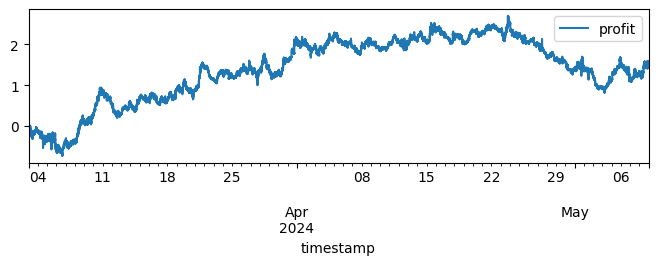

In [19]:
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

983


<AxesSubplot:xlabel='timestamp'>

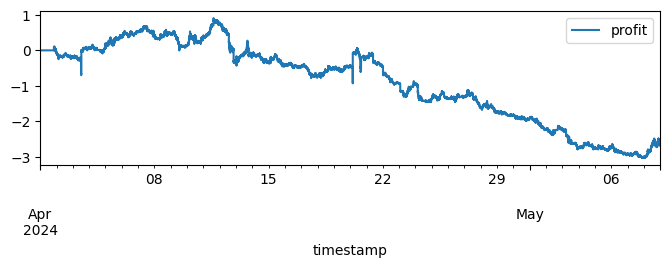

In [13]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.CEX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-01', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

891


<AxesSubplot:xlabel='timestamp'>

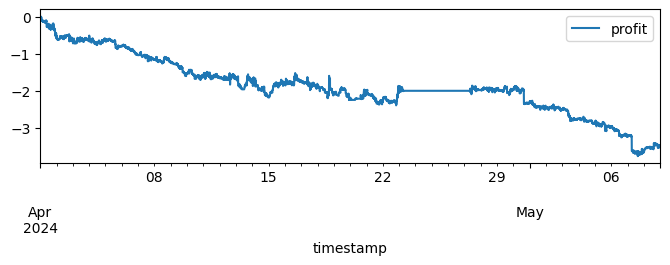

In [14]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.GEMINI,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-01', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

2024-05-19 19:50:10,122 [MainThread  ] [INFO ]  filename='/Users/junlim/algo_cache/trading/(momentum_trading)_feature_param(window(360)_ema_window(60))_selection_size(2)_rebalance_interval_minutes(360)/trading-290017.market_data_bithumb.orderbook_level1/2024-04-01T00:00:00-0400_2024-04-02T00:00:00-0400.parquet' does not exist in local cache. For gcs, blob_exist=False.
2024-05-19 19:50:10,123 [MainThread  ] [INFO ]  df_cache is None for (datetime.datetime(2024, 4, 1, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>), datetime.datetime(2024, 4, 2, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>))
2024-05-19 19:50:10,174 [MainThread  ] [INFO ]  filename='/Users/junlim/algo_cache/trading/(momentum_trading)_feature_param(window(360)_ema_window(60))_selection_size(2)_rebalance_interval_minutes(360)/trading-290017.market_data_bithumb.orderbook_level1/2024-04-02T00:00:00-0400_2024-04-03T00:00:00-0400.parquet' does not exist in local cache. For gcs, blob_e

<AxesSubplot:xlabel='timestamp'>

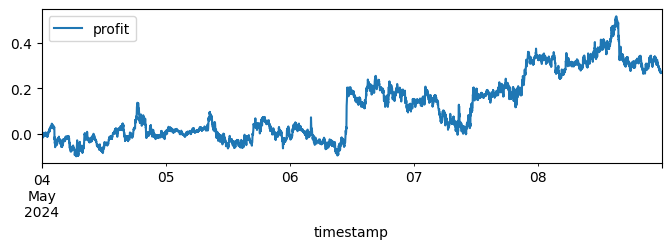

In [17]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.BITHUMB,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.ORDERBOOK_LEVEL1,
    date_str_from='2024-04-01', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [20]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(window=180, ema_window=30)
trading_param = algo.alpha.momentum.calculate.MomentumTradingParam(
    feature_param, selection_size=2, rebalance_interval_minutes=3*60)

3502


<AxesSubplot:xlabel='timestamp'>

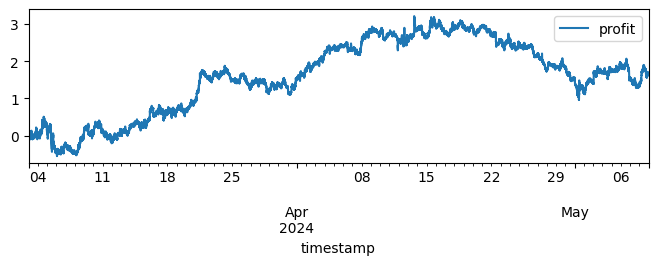

In [21]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-03-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

1926


<AxesSubplot:xlabel='timestamp'>

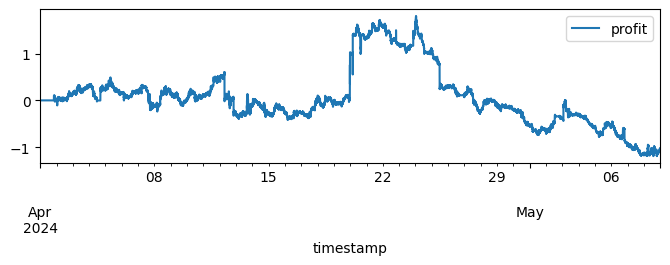

In [22]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.CEX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-01', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

1743


<AxesSubplot:xlabel='timestamp'>

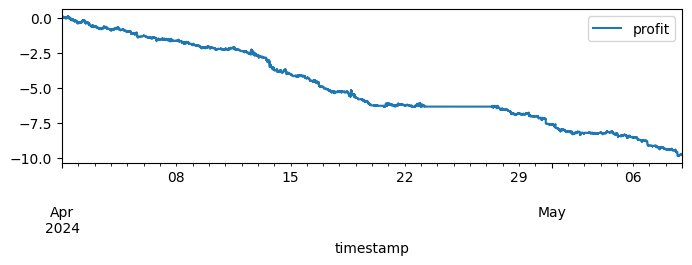

In [23]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.GEMINI,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-01', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [1058]:
dfst_trading[
    dfst_trading.in_position == 1
][['in_position']].groupby('timestamp').sum().plot(figsize=(8,1))

AttributeError: 'DataFrame' object has no attribute 'in_position'

<AxesSubplot:xlabel='timestamp'>

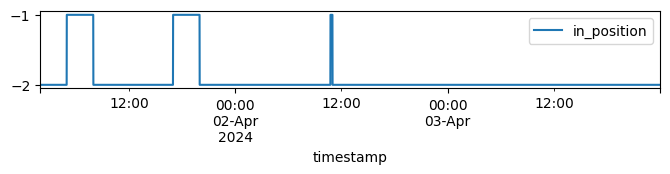

In [981]:
dfst_trading[
    dfst_trading.in_position == -1
][['in_position']].groupby('timestamp').sum().plot(figsize=(8,1))

<AxesSubplot:xlabel='timestamp'>

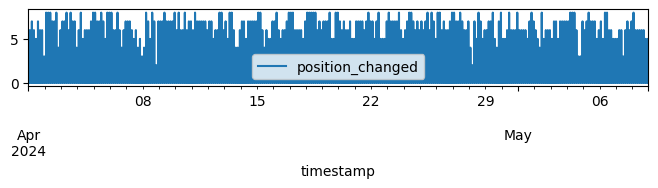

In [1060]:
dfst_trading[['position_changed']].abs().groupby('timestamp').sum().plot(figsize=(8,1))

In [1061]:
dfst_trading.columns

Index(['profit', 'value', 'position_changed'], dtype='object')

In [1062]:
len(dfst_trading[dfst_trading.profit.fillna(0) != 0][['profit']].groupby('symbol').sum().sort_values('profit'))

147

In [26]:
dfst_trading[dfst_trading.profit.fillna(0) != 0][['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
QRDOUSD,-2.125710
LUNAUSD,-0.930137
ERNUSD,-0.876574
ZBCUSD,-0.699040
ALIUSD,-0.649819
...,...
API3USD,0.040561
OXTUSD,0.050041
IOTXUSD,0.061196


In [985]:
len(dfst_trading[(dfst_trading.position_changed != 0)].dropna())

164

In [986]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-04-01 02:00:00-04:00, JOE-USDT-SWAP, 0.843, position_changed: -1.0
2024-04-01 02:00:00-04:00, LQTY-USDT-SWAP, 2.003, position_changed: 1.0
2024-04-01 02:00:00-04:00, RAY-USDT-SWAP, 2.2908, position_changed: -1.0
2024-04-01 02:00:00-04:00, RVN-USDT-SWAP, 0.05145, position_changed: 1.0
2024-04-01 04:21:00-04:00, RVN-USDT-SWAP, 0.04754, position_changed: -1.0
2024-04-01 05:00:00-04:00, JOE-USDT-SWAP, 0.8753, position_changed: 1.0
2024-04-01 05:00:00-04:00, CORE-USDT-SWAP, 2.6991, position_changed: 1.0
2024-04-01 05:00:00-04:00, RAY-USDT-SWAP, 2.3258, position_changed: 1.0
2024-04-01 05:00:00-04:00, RVN-USDT-SWAP, 0.04778, position_changed: -1.0
2024-04-01 05:00:00-04:00, LQTY-USDT-SWAP, 1.88, position_changed: -1.0
2024-04-01 05:00:00-04:00, DGB-USDT-SWAP, 0.020195, position_changed: 1.0
2024-04-01 07:47:00-04:00, DGB-USDT-SWAP, 0.018109, position_changed: -1.0
2024-04-01 08:00:00-04:00, DGB-USDT-SWAP, 0.018132, position_changed: -1.0
2024-04-01 08:00:00-04:00, SUI-USDT-SWAP, 1.966, 

## single symbol

In [1064]:
import algo.alpha.momentum.calculate
importlib.reload(algo.alpha.momentum.calculate)
import algo.alpha.momentum.research
importlib.reload(algo.alpha.momentum.research)
import algo.alpha.momentum.research
importlib.reload(algo.alpha.momentum.research)

<module 'algo.alpha.momentum.research' from '/Users/junlim/projects/jitter_recovery/algo/alpha/momentum/research.py'>

In [37]:
symbol_investigate = 'QRDOUSD'

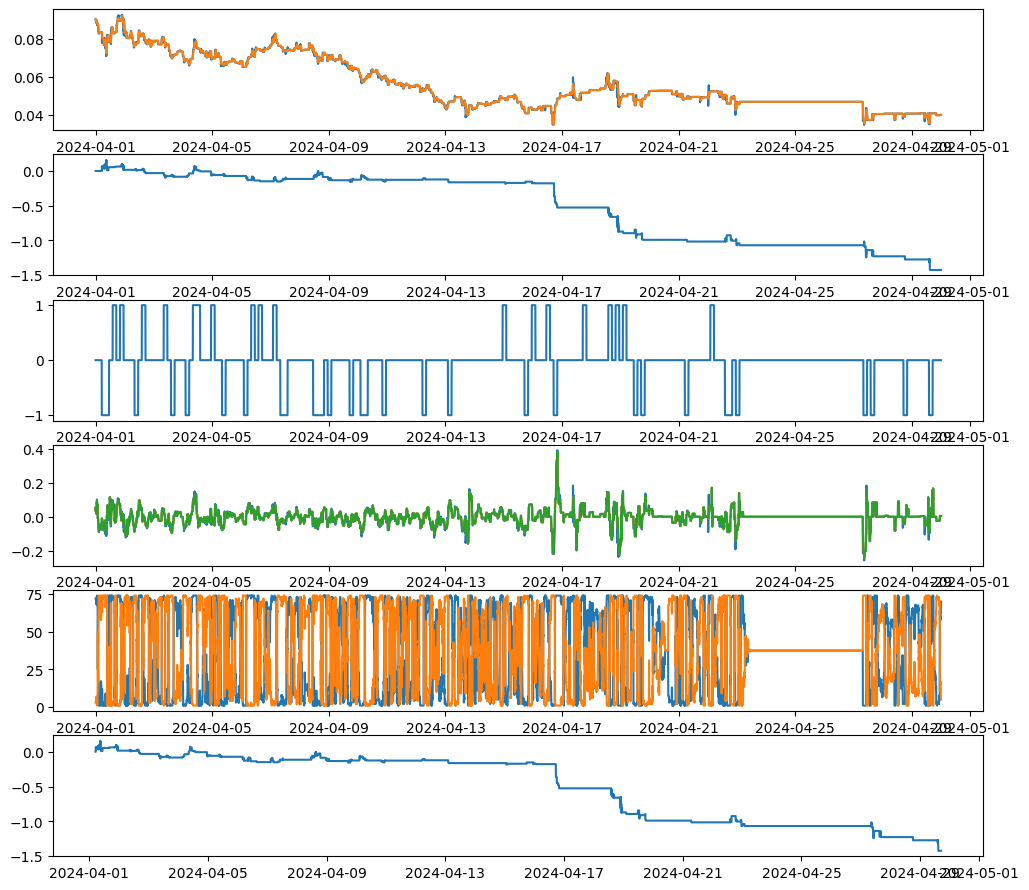

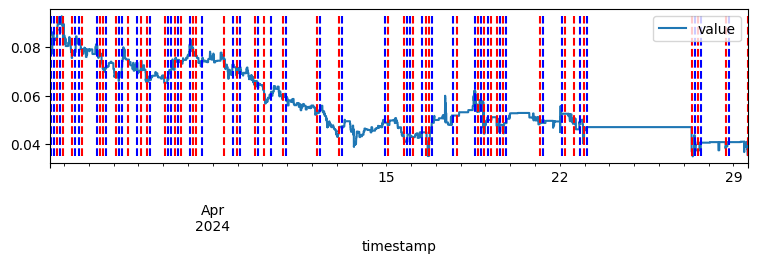

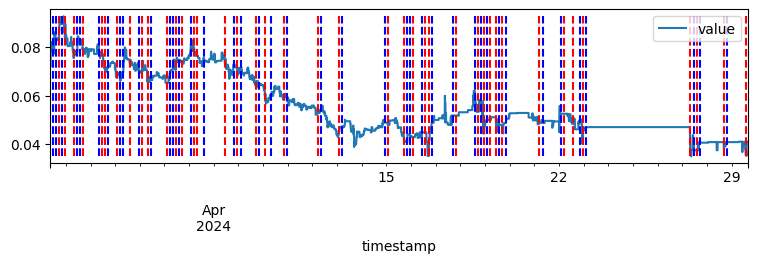

In [38]:
df_feature, df_trading = algo.alpha.momentum.research.investigate_symbol(
    dfst_feature, symbol_investigate, trading_param, figsize=(12, 11))

In [39]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-04-01 05:00:00-04:00,0.08360,-1,-1.0,0.0,0.0
2024-04-01 11:00:00-04:00,0.07848,0,1.0,-0.0,-0.0
2024-04-01 14:00:00-04:00,0.08298,1,1.0,0.0,0.0
2024-04-01 17:00:00-04:00,0.08369,0,-1.0,0.0,0.0
2024-04-01 20:00:00-04:00,0.08966,1,1.0,0.0,0.0
...,...,...,...,...,...
2024-04-27 17:00:00-04:00,0.04064,0,1.0,-0.0,-0.0
2024-04-28 17:00:00-04:00,0.03909,-1,-1.0,0.0,0.0
2024-04-28 20:00:00-04:00,0.04087,0,1.0,-0.0,-0.0


In [40]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-04-01 05:00:00-04:00, QRDOUSD, 0.0836, position_changed: -1.0
2024-04-01 11:00:00-04:00, QRDOUSD, 0.07848, position_changed: 1.0
2024-04-01 14:00:00-04:00, QRDOUSD, 0.08298, position_changed: 1.0
2024-04-01 17:00:00-04:00, QRDOUSD, 0.08369, position_changed: -1.0
2024-04-01 20:00:00-04:00, QRDOUSD, 0.08966, position_changed: 1.0
2024-04-01 23:00:00-04:00, QRDOUSD, 0.08524, position_changed: -1.0
2024-04-02 08:00:00-04:00, QRDOUSD, 0.07772, position_changed: -1.0
2024-04-02 11:00:00-04:00, QRDOUSD, 0.078, position_changed: 1.0
2024-04-02 14:00:00-04:00, QRDOUSD, 0.08148, position_changed: 1.0
2024-04-02 17:00:00-04:00, QRDOUSD, 0.07799, position_changed: -1.0
2024-04-03 08:00:00-04:00, QRDOUSD, 0.08081, position_changed: 1.0
2024-04-03 11:00:00-04:00, QRDOUSD, 0.07734, position_changed: -1.0
2024-04-03 14:00:00-04:00, QRDOUSD, 0.07126, position_changed: -1.0
2024-04-03 17:00:00-04:00, QRDOUSD, 0.07188, position_changed: 1.0
2024-04-04 02:00:00-04:00, QRDOUSD, 0.06933, position_chan